In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pywt
from PIL import Image  
import PIL  
from skimage.io import imsave, imread

In [3]:
from dask import bag, diagnostics 

In [4]:
import shutil
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, zero_one_loss, classification_report
from tensorflow import keras
import matplotlib.cm as cm
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from keras.layers import Input
from keras.layers import Convolution2D , concatenate ,Conv2D,Dense
from keras.layers import Activation,Dropout, GlobalAveragePooling2D,MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam ,SGD,RMSprop

In [5]:
import math
from keras.layers import MaxPool2D, concatenate, AveragePooling2D
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import h5py
from keras.layers import Concatenate
import keras.backend as K
import keras
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler

In [6]:
from glob import glob 
from tensorflow.keras.layers import Lambda
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
data_path = '/content/drive/MyDrive/Sem 2/CV/5G_Data/'

In [8]:
classes = list(os.listdir('/content/drive/MyDrive/Sem 2/CV/5G_Data/'))
print(classes)

['4QAM', '64QAM', '16QAM', '32QAM', '8QAM']


In [9]:
directories = {
    '4QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data_rev/4QAM/',
    '8QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data/8QAM/',
    '16QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data_rev/16QAM/',
    '32QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data/32QAM/',
    '64QAM': '/content/drive/MyDrive/Sem 2/CV/5G_Data_rev/64QAM/',}

In [10]:
import PIL.Image

def cs_images(path,img_shape, classes):
    imag = []
    label = []
    for i in classes:
        l1 = os.listdir(path+'/'+i)
        for j in l1:
            img = PIL.Image.open(path+'/'+i+'/'+j)
            img = img.resize(size = (img_shape[0], img_shape[0]))
            img = img.convert('RGB')
            #img = img.convert('L')
            #img = img.reshape(50,50,1)
            #img = img.flatten()
            img = cv2.imread(path+'/'+i+'/'+j)
            img = cv2.resize(img,(img_shape[0],img_shape[1]),3)
            #img = np.array(img).reshape(img_shape)
            #img = img.reshape(img_shape)
            imag.append(img)
            label.append(classes.index(i))
            del(img)
    # %matplotlib inline 
    # plt.figure(figsize=(10, 10))
    # for i in range(20):
    #     plt.subplot(5,4,i+1)
    #     plt.imshow(imag[i])
    #     plt.axis('off')
    # plt.show()
    return np.array(imag),label

In [11]:
IMG_SIZE = 224

In [12]:
x,y = cs_images(data_path,(IMG_SIZE, IMG_SIZE, 1),classes)

In [13]:
y = pd.Series(y)

In [14]:
x_train,x_test,y_train,y_test = train_test_split(x,y,
                                                 test_size = 0.1,
                                                 random_state = 12,
                                                 shuffle = True)

In [15]:
x_train.shape

(1801, 224, 224, 3)

In [16]:
y_train[:10]

1924    4
122     0
1502    3
1568    3
1431    3
177     0
1264    3
468     1
324     0
161     0
dtype: int64

In [17]:
y_train.shape

(1801,)

In [18]:
x_test.shape

(201, 224, 224, 3)

In [19]:
y_test.shape

(201,)

In [20]:
IMG_SIZE = 224

# VGG

In [21]:
base_model = VGG19(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(len(classes), activation='softmax'))

80134624/80134624 [==============================] - 3s 0us/step


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 23,236,421
Trainable params: 10,291,461
No

In [23]:
import torch

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

print(device)

cuda:0


In [24]:
#opt = keras.optimizers.Adam(learning_rate=0.01)

opt = tf.keras.optimizers.experimental.SGD(0.001, momentum=0.01,
                                           clipnorm = 1,
                                           weight_decay=0.00001)
#Compile the model 
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer= opt, 
              metrics=['sparse_categorical_accuracy']) 

In [25]:
history = model.fit(x_train,
                    y_train,
                    epochs= 30,
                    validation_data = (x_test,y_test),
                    verbose = 1,
                    #callbacks = [es],
                    batch_size=32)

Epoch 1/30
57/57 [==============================] - 27s 212ms/step - loss: 7.0532 - sparse_categorical_accuracy: 0.2482 - val_loss: 3.6764 - val_sparse_categorical_accuracy: 0.2786
Epoch 2/30
57/57 [==============================] - 10s 177ms/step - loss: 4.6363 - sparse_categorical_accuracy: 0.2971 - val_loss: 2.8321 - val_sparse_categorical_accuracy: 0.2786
Epoch 3/30
57/57 [==============================] - 11s 188ms/step - loss: 3.2107 - sparse_categorical_accuracy: 0.3770 - val_loss: 2.2802 - val_sparse_categorical_accuracy: 0.3234
Epoch 4/30
57/57 [==============================] - 10s 184ms/step - loss: 2.7114 - sparse_categorical_accuracy: 0.3620 - val_loss: 1.9368 - val_sparse_categorical_accuracy: 0.3483
Epoch 5/30
57/57 [==============================] - 11s 191ms/step - loss: 2.3109 - sparse_categorical_accuracy: 0.3876 - val_loss: 1.6738 - val_sparse_categorical_accuracy: 0.3532
Epoch 6/30
57/57 [==============================] - 11s 193ms/step - loss: 1.9461 - sparse_cate

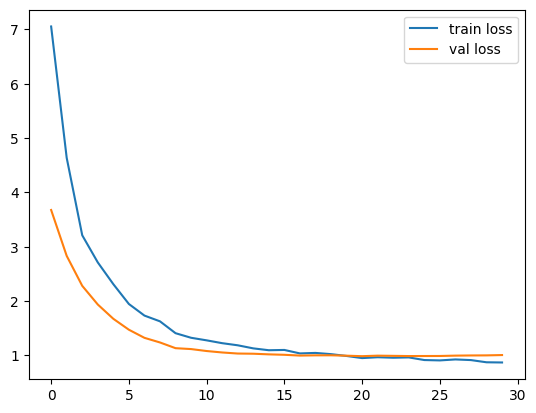

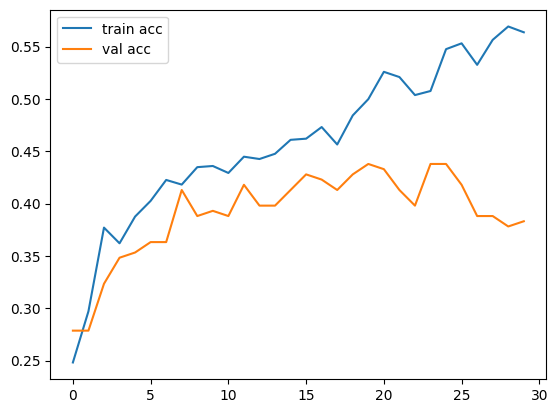

In [27]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
 
 # accuracies
plt.plot(history.history['sparse_categorical_accuracy'], label='train acc')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val acc')
plt.legend()
plt.show()

In [28]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/Sem 2/CV/Saved_models/5g_2_data_vgg19.h5')

In [29]:
y_pred = np.argmax(model.predict(x_test),axis=1)

7/7 [==============================] - 1s 146ms/step


In [30]:
y_pred[0:5]

array([2, 1, 1, 2, 4])

In [31]:
list(y_test[0:5])

[0, 3, 1, 2, 4]

In [32]:
model.evaluate(x_test,y_test)

7/7 [==============================] - 1s 138ms/step - loss: 1.0066 - sparse_categorical_accuracy: 0.3831


[1.006611943244934, 0.38308456540107727]

In [33]:
print(classes)
# print(y_test[:25], '\n')
# print(y_pred[:25], '\n')

# predict = []
# for i in range(3000): #len(y_pred)
#   predict.append(np.argmax(y_pred[i]))

# print(predict[:25], '\n')

cm = confusion_matrix(y_test, y_pred)
print(cm, '\n')

zol = zero_one_loss(y_test, y_pred, normalize = False)
print(zol, '\n')

cr = classification_report(y_test, y_pred)
print(cr)

['4QAM', '64QAM', '16QAM', '32QAM', '8QAM']
[[15  0 31  0  0]
 [ 0 15  0 15  8]
 [20  0 25  0  0]
 [ 0 13  0 11 13]
 [ 0 14  0 10 11]] 

124 

              precision    recall  f1-score   support

           0       0.43      0.33      0.37        46
           1       0.36      0.39      0.38        38
           2       0.45      0.56      0.50        45
           3       0.31      0.30      0.30        37
           4       0.34      0.31      0.33        35

    accuracy                           0.38       201
   macro avg       0.38      0.38      0.37       201
weighted avg       0.38      0.38      0.38       201



<Figure size 500x500 with 0 Axes>

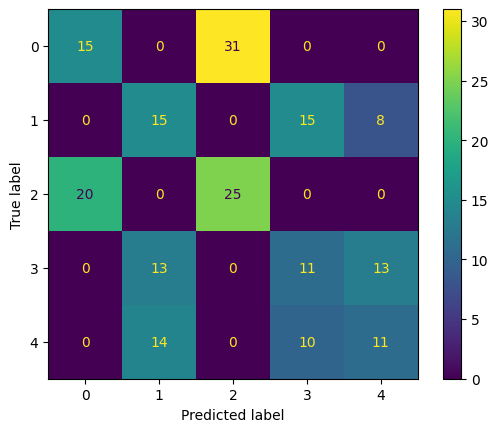

In [34]:
plt.figure(figsize = (5,5))
ConfusionMatrixDisplay(cm).plot()
plt.show()